<a href="https://colab.research.google.com/github/ravi-gopalan/ashrae/blob/master/ashrae_energy_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
cd /root

/root


In [0]:
!mkdir .kaggle 

In [0]:
!cp '/gdrive/My Drive/Colab_stuff/kaggle.json' '/root/.kaggle/kaggle.json' 
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
cd /content/

/content


In [0]:
!mkdir ashrae_energy_prediction

In [7]:
cd ashrae_energy_prediction/

/content/ashrae_energy_prediction


In [8]:
!kaggle competitions download -c ashrae-energy-prediction

100% 166M/167M [00:00<00:00, 163MB/s]
100% 167M/167M [00:00<00:00, 181MB/s]
 83% 73.0M/88.4M [00:00<00:00, 57.1MB/s]
100% 88.4M/88.4M [00:01<00:00, 86.8MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 34.3MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 173MB/s]
 84% 101M/120M [00:00<00:00, 100MB/s]  
100% 120M/120M [00:00<00:00, 189MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 180MB/s]


In [9]:
!unzip train.csv.zip
!unzip test.csv.zip
!unzip weather_train.csv.zip
!unzip weather_test.csv.zip
!unzip sample_submission.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  weather_train.csv.zip
  inflating: weather_train.csv       
Archive:  weather_test.csv.zip
  inflating: weather_test.csv        
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [10]:
!ls

building_metadata.csv	   test.csv.zip      weather_test.csv.zip
sample_submission.csv	   train.csv	     weather_train.csv
sample_submission.csv.zip  train.csv.zip     weather_train.csv.zip
test.csv		   weather_test.csv


# Library Imports

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import gc
import sys

import lightgbm as lgb

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Helper functions

In [0]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Building MetaData EDA

In [13]:
primary_use_map = {'Education':0, \
                   'Lodging/residential':1, \
                   'Office':2,\
                   'Entertainment/public assembly':3,\
                   'Other':4,\
                   'Retail':5,\
                   'Parking':6,\
                   'Public services':7,\
                   'Warehouse/storage':8,\
                   'Food sales and service':9,\
                   'Religious worship':10,\
                   'Healthcare':11,\
                   'Utility':12,\
                   'Technology/science':13,\
                   'Manufacturing/industrial':14,\
                   'Services':15\
                   }

df_building_metadata = pd.read_csv('building_metadata.csv')
df_building_metadata.info()
df_building_metadata.head()

df_building_metadata['use_category'] = df_building_metadata['primary_use'].map(primary_use_map)
df_building_metadata.drop(columns=['primary_use'],inplace=True)
df_building_metadata = reduce_mem_usage(df_building_metadata)
df_building_metadata.info()
df_building_metadata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN

Mem. usage decreased to  0.02 Mb (74.9% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id         1449 non-null int8
building_id     1449 non-null int16
square_feet     1449 non-null int32
year_built      675 non-null float16
floor_count     355 non-null float16
use_category    1449 non-null int8
dtypes: float16(2), int16(1), int32(1), int8(2)
memory usage: 17.1 KB


site_id  building_id  square_feet  year_built  floor_count  use_category
0        0            0         7432      2008.0          NaN             0
1        0            1         2720      2004.0          NaN             0
2        0            2         5376      1991.0          NaN             0
3        0            3        23685      2002.0          NaN             0
4        0            4       116607      1975.0          NaN             0

In [14]:
print('Missing Values in %:\n{}'.format(100*df_building_metadata.isna().sum()/df_building_metadata.shape[0]))

Missing Values in %:
site_id          0.000000
building_id      0.000000
square_feet      0.000000
year_built      53.416149
floor_count     75.500345
use_category     0.000000
dtype: float64


In [15]:
df_building_metadata[['use_category','floor_count']].query('floor_count != floor_count').groupby(['use_category'])['use_category'].count()
df_building_metadata[['use_category','floor_count']].query('floor_count == floor_count').groupby(['use_category'])['use_category'].count()

use_category
0     377
1     129
2     239
3     128
4      12
5       9
6      19
7     115
8      11
9       5
10      3
11     22
12      3
13      3
14      9
15     10
Name: use_category, dtype: int64

use_category
0     172
1      18
2      40
3      56
4      13
5       2
6       3
7      41
8       2
11      1
12      1
13      3
14      3
Name: use_category, dtype: int64

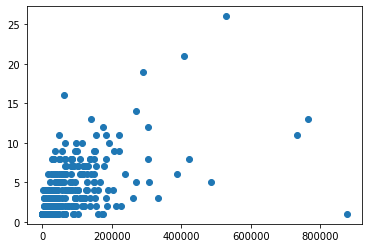

In [16]:
plt.scatter(df_building_metadata.query('floor_count == floor_count')['square_feet'],\
            df_building_metadata.query('floor_count == floor_count')['floor_count'])

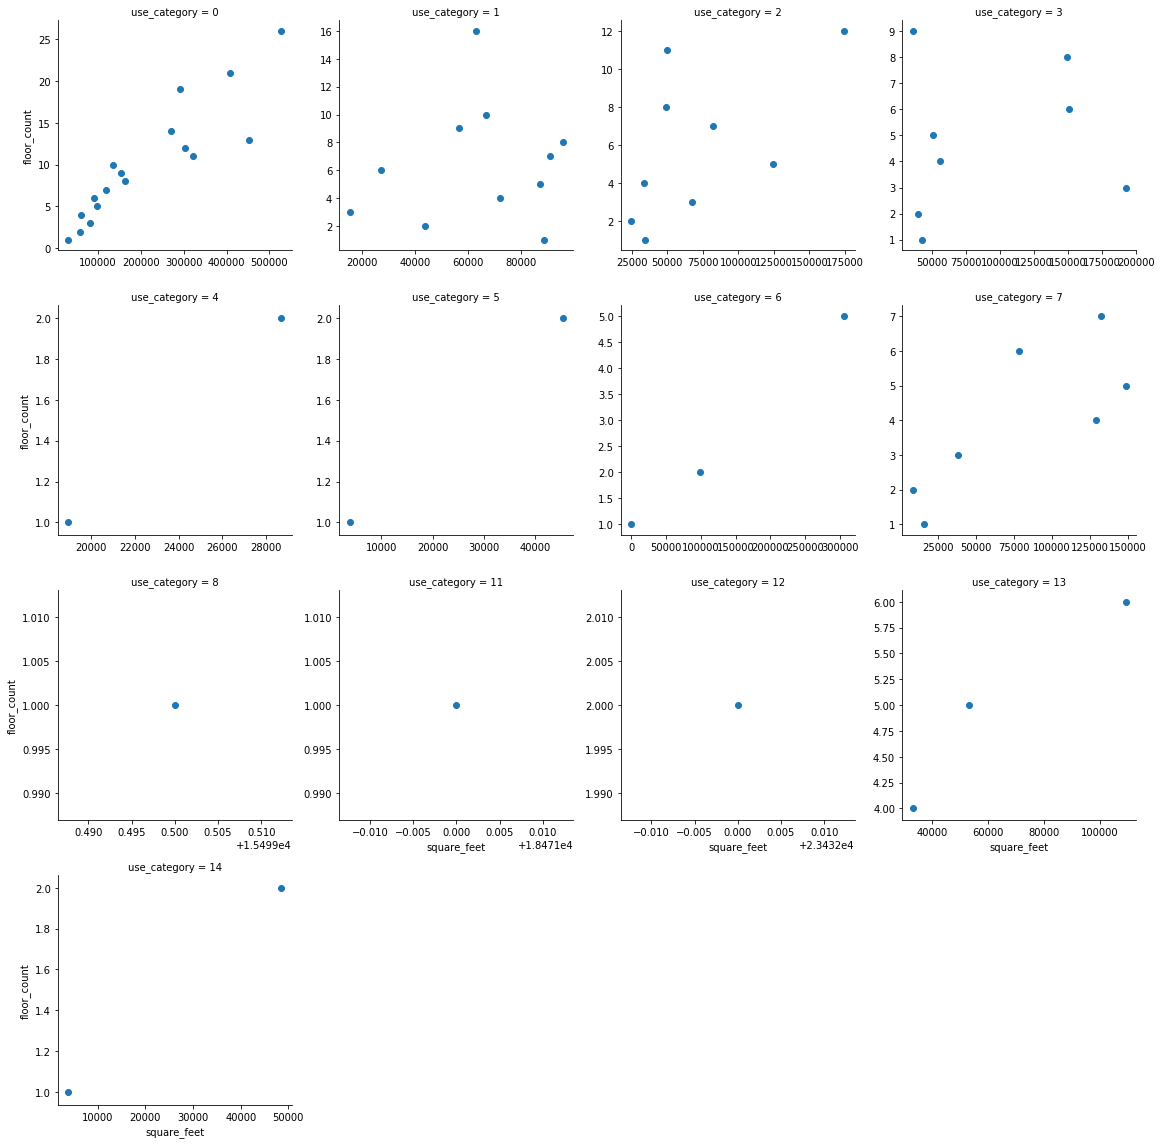

In [17]:
g = sns.FacetGrid(df_building_metadata[['use_category','floor_count','square_feet']].groupby(['use_category','floor_count'],as_index=False)\
['square_feet'].mean(), col='use_category',col_wrap=4,sharey=False,sharex=False,height = 4)
g = (g.map(plt.scatter, 'square_feet','floor_count').add_legend())

0


0.8217473965887317

(array([4.14617628e-05]), 1.3456142321983666)

array([ 5.49179052,  9.6379668 , 13.78414309, 17.93031937, 22.07649565,
       26.22267194, 30.36884822])

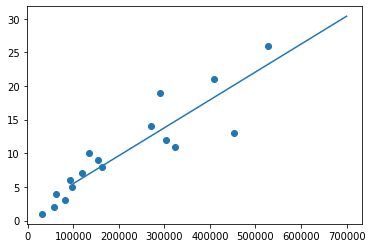

site_id  building_id  square_feet  year_built  floor_count  use_category
0           0            0         7432      2008.0          NaN             0
1           0            1         2720      2004.0          NaN             0
2           0            2         5376      1991.0          NaN             0
3           0            3        23685      2002.0          NaN             0
4           0            4       116607      1975.0          NaN             0
...       ...          ...          ...         ...          ...           ...
1438       15         1438       108971      1990.0          NaN             0
1439       15         1439        56497      1957.0          NaN             0
1441       15         1441        30143      1951.0          NaN             0
1443       15         1443        40311      1913.0          NaN             0
1445       15         1445         4298         NaN          NaN             0

[377 rows x 6 columns]

0         7432
1         2720
2         5376
3        23685
4       116607
         ...  
1438    108971
1439     56497
1441     30143
1443     40311
1445      4298
Name: square_feet, Length: 377, dtype: int32

Series([], Name: floor_count, dtype: float16)

1


0.01328270219013894

(array([1.84631688e-05]), 5.269716354076265)

array([ 7.11603324,  8.96235012, 10.808667  , 12.65498389, 14.50130077,
       16.34761765, 18.19393454])

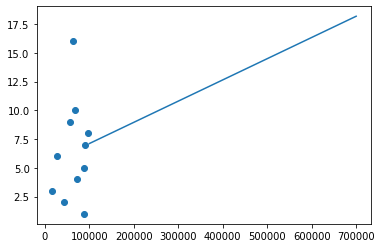

site_id  building_id  square_feet  year_built  floor_count  use_category
6           0            6        27926      1981.0          NaN             1
12          0           12        37100      1999.0          NaN             1
27          0           27        59200      1999.0          NaN             1
33          0           33        38686      2002.0          NaN             1
34          0           34        42731      2002.0          NaN             1
...       ...          ...          ...         ...          ...           ...
1422       15         1422        19876      1932.0          NaN             1
1423       15         1423        18277      1965.0          NaN             1
1424       15         1424        24103      1964.0          NaN             1
1440       15         1440       150294      1987.0          NaN             1
1447       15         1447        29775      2001.0          NaN             1

[129 rows x 6 columns]

6        27926
12       37100
27       59200
33       38686
34       42731
         ...  
1422     19876
1423     18277
1424     24103
1440    150294
1447     29775
Name: square_feet, Length: 129, dtype: int32

Series([], Name: floor_count, dtype: float16)

2


0.3319366139794152

(array([4.54412192e-05]), 2.650088287469379)

array([ 7.19421021, 11.73833214, 16.28245406, 20.82657598, 25.37069791,
       29.91481983, 34.45894175])

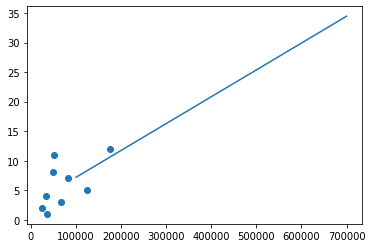

site_id  building_id  square_feet  year_built  floor_count  use_category
9           0            9        27000      2010.0          NaN             2
15          0           15        83957      1974.0          NaN             2
17          0           17        15250      1980.0          NaN             2
19          0           19        18717      2004.0          NaN             2
21          0           21         7043      1990.0          NaN             2
...       ...          ...          ...         ...          ...           ...
1381       15         1381        84615      1963.0          NaN             2
1387       15         1387       187041      1973.0          NaN             2
1410       15         1410        11524      1994.0          NaN             2
1430       15         1430        53303      1981.0          NaN             2
1448       15         1448        92271      2001.0          NaN             2

[239 rows x 6 columns]

9        27000
15       83957
17       15250
19       18717
21        7043
         ...  
1381     84615
1387    187041
1410     11524
1430     53303
1448     92271
Name: square_feet, Length: 239, dtype: int32

Series([], Name: floor_count, dtype: float16)

3


0.02348465136008193

(array([6.81208623e-06]), 4.137016216082047)

array([4.81822484, 5.49943346, 6.18064208, 6.86185071, 7.54305933,
       8.22426795, 8.90547658])

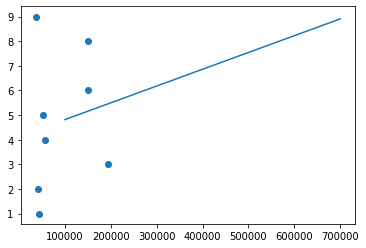

site_id  building_id  square_feet  year_built  floor_count  use_category
10          0           10       370773      1991.0          NaN             3
40          0           40        26944      2001.0          NaN             3
59          0           59        81337      2005.0          NaN             3
87          0           87         6412      2006.0          NaN             3
88          0           88        76527      2007.0          NaN             3
...       ...          ...          ...         ...          ...           ...
1408       15         1408        28760      2007.0          NaN             3
1420       15         1420        95079      1975.0          NaN             3
1426       15         1426        15450      1948.0          NaN             3
1444       15         1444        19619      1914.0          NaN             3
1446       15         1446        11265      1997.0          NaN             3

[128 rows x 6 columns]

10      370773
40       26944
59       81337
87        6412
88       76527
         ...  
1408     28760
1420     95079
1426     15450
1444     19619
1446     11265
Name: square_feet, Length: 128, dtype: int32

Series([], Name: floor_count, dtype: float16)

4


1.0

(array([0.0001027]), -0.9467252047549355)

array([ 9.32311484, 19.59295489, 29.86279494, 40.13263498, 50.40247503,
       60.67231508, 70.94215513])

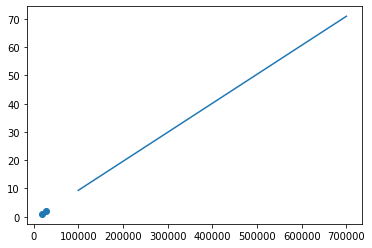

site_id  building_id  square_feet  year_built  floor_count  use_category
42          0           42       226506      1968.0          NaN             4
48          0           48         9569      1989.0          NaN             4
50          0           50         4698      1981.0          NaN             4
81          0           81         3025      1979.0          NaN             4
83          0           83         2070      1996.0          NaN             4
503         3          503        10762         NaN          NaN             4
506         3          506        34400         NaN          NaN             4
508         3          508       112283         NaN          NaN             4
509         3          509        10578         NaN          NaN             4
1103       13         1103        23903         NaN          NaN             4
1114       13         1114        64810         NaN          NaN             4
1174       13         1174        27648         NaN          NaN             4

42      226506
48        9569
50        4698
81        3025
83        2070
503      10762
506      34400
508     112283
509      10578
1103     23903
1114     64810
1174     27648
Name: square_feet, dtype: int32

Series([], Name: floor_count, dtype: float16)

5


1.0

(array([2.41557563e-05]), 0.9056234600705352)

array([ 3.32119909,  5.73677472,  8.15235036, 10.56792599, 12.98350162,
       15.39907725, 17.81465288])

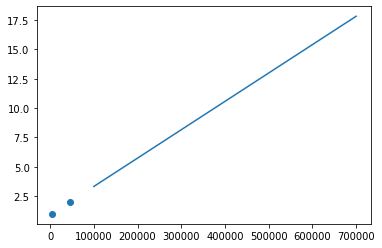

site_id  building_id  square_feet  year_built  floor_count  use_category
43          0           43        59071      1980.0          NaN             5
44          0           44          283      1985.0          NaN             5
45          0           45        15304      2016.0          NaN             5
46          0           46         9045      2016.0          NaN             5
47          0           47        31666      2008.0          NaN             5
89          0           89       161755      1996.0          NaN             5
170         2          170        45224      1982.0          NaN             5
368         3          368        16500         NaN          NaN             5
1061       12         1061        44218         NaN          NaN             5

43       59071
44         283
45       15304
46        9045
47       31666
89      161755
170      45224
368      16500
1061     44218
Name: square_feet, dtype: int32

Series([], Name: floor_count, dtype: float16)

6


0.9940469432638632

(array([1.32950922e-05]), 0.8715367258252287)

array([ 2.20104595,  3.53055517,  4.86006439,  6.18957361,  7.51908283,
        8.84859205, 10.17810128])

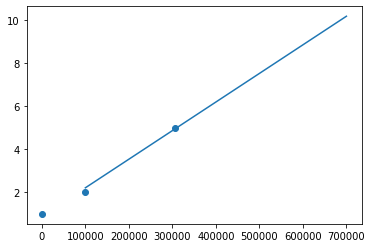

site_id  building_id  square_feet  year_built  floor_count  use_category
51          0           51       387638      2014.0          NaN             6
68          0           68       487433      2007.0          NaN             6
69          0           69       387638      2000.0          NaN             6
70          0           70       387638      2007.0          NaN             6
71          0           71       387638      1998.0          NaN             6
72          0           72       387638      2002.0          NaN             6
73          0           73       387638      2008.0          NaN             6
74          0           74       387638      1997.0          NaN             6
199         2          199       405083      2004.0          NaN             6
242         2          242       157113      1987.0          NaN             6
243         2          243       557217      2004.0          NaN             6
431         3          431         1760         NaN          NaN             6
1096       13         1096        83772         NaN          NaN             6
1108       13         1108       679614         NaN          NaN             6
1125       13         1125       271492         NaN          NaN             6
1141       13         1141        20986         NaN          NaN             6
1163       13         1163        83919         NaN          NaN             6
1205       13         1205       178270         NaN          NaN             6
1215       13         1215       100328         NaN          NaN             6

51      387638
68      487433
69      387638
70      387638
71      387638
72      387638
73      387638
74      387638
199     405083
242     157113
243     557217
431       1760
1096     83772
1108    679614
1125    271492
1141     20986
1163     83919
1205    178270
1215    100328
Name: square_feet, dtype: int32

Series([], Name: floor_count, dtype: float16)

7


0.6175952150599452

(array([2.88284481e-05]), 1.7299190993432352)

array([ 4.61276391,  7.49560873, 10.37845354, 13.26129835, 16.14414317,
       19.02698798, 21.90983279])

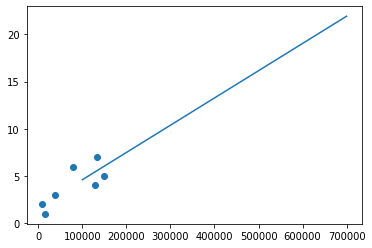

site_id  building_id  square_feet  year_built  floor_count  use_category
156         2          156        43681      2007.0          NaN             7
197         2          197       102856         NaN          NaN             7
206         2          206       345837      1966.0          NaN             7
207         2          207        99700         NaN          NaN             7
218         2          218        16411         NaN          NaN             7
...       ...          ...          ...         ...          ...           ...
1371       15         1371        50577      1956.0          NaN             7
1376       15         1376       240026      1960.0          NaN             7
1382       15         1382       243072      1965.0          NaN             7
1431       15         1431       111360      2000.0          NaN             7
1442       15         1442        99541      1993.0          NaN             7

[115 rows x 6 columns]

156      43681
197     102856
206     345837
207      99700
218      16411
         ...  
1371     50577
1376    240026
1382    243072
1431    111360
1442     99541
Name: square_feet, Length: 115, dtype: int32

Series([], Name: floor_count, dtype: float16)

8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

(array([0.]), 1.0)

array([1., 1., 1., 1., 1., 1., 1.])

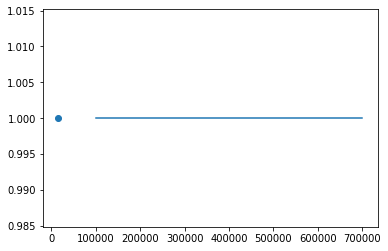

site_id  building_id  square_feet  year_built  floor_count  use_category
164         2          164        12908      1979.0          NaN             8
165         2          165         3877      1975.0          NaN             8
383         3          383        27318         NaN          NaN             8
413         3          413        14839      2005.0          NaN             8
425         3          425       202829      1983.0          NaN             8
504         3          504       112536         NaN          NaN             8
505         3          505        51622      1975.0          NaN             8
1155       13         1155        19059         NaN          NaN             8
1182       13         1182        66585         NaN          NaN             8
1199       13         1199        10559         NaN          NaN             8
1213       13         1213        39464         NaN          NaN             8

164      12908
165       3877
383      27318
413      14839
425     202829
504     112536
505      51622
1155     19059
1182     66585
1199     10559
1213     39464
Name: square_feet, dtype: int32

Series([], Name: floor_count, dtype: float16)

9


0.5753850115994188

(array([2.66399943e-05]), 2.768164245432902)

array([ 5.43216367,  8.0961631 , 10.76016253, 13.42416196, 16.08816139,
       18.75216081, 21.41616024])

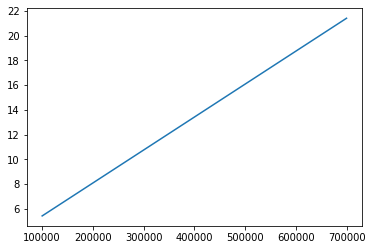

site_id  building_id  square_feet  year_built  floor_count  use_category
179         2          179        24867      2012.0          NaN             9
281         2          281        28862         NaN          NaN             9
1105       13         1105        33215         NaN          NaN             9
1247       14         1247        69876         NaN          NaN             9
1265       14         1265        35605         NaN          NaN             9

179     24867
281     28862
1105    33215
1247    69876
1265    35605
Name: square_feet, dtype: int32

Series([], Name: floor_count, dtype: float16)

10


0.5754580993440345

(array([2.66373207e-05]), 2.769146397612691)

array([ 5.43287847,  8.09661054, 10.76034261, 13.42407468, 16.08780675,
       18.75153882, 21.41527089])

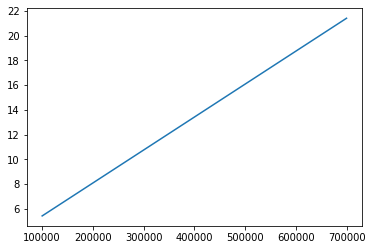

site_id  building_id  square_feet  year_built  floor_count  use_category
186         2          186         1629      1948.0          NaN            10
538         3          538        10000      2010.0          NaN            10
1353       15         1353        22201         NaN          NaN            10

186      1629
538     10000
1353    22201
Name: square_feet, dtype: int32

Series([], Name: floor_count, dtype: float16)

11


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

(array([0.]), 1.0)

array([1., 1., 1., 1., 1., 1., 1.])

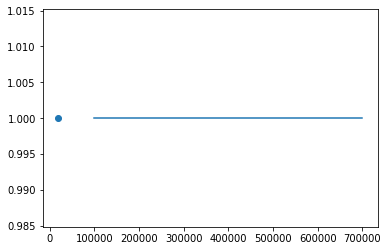

site_id  building_id  square_feet  year_built  floor_count  use_category
208         2          208        36904      1934.0          NaN            11
365         3          365       819577      1922.0          NaN            11
455         3          455        29192      2014.0          NaN            11
535         3          535        15000      2010.0          NaN            11
547         3          547        23903         NaN          NaN            11
548         3          548         9813      2010.0          NaN            11
556         3          556       450000      2012.0          NaN            11
1072       13         1072       305000         NaN          NaN            11
1207       13         1207        74443         NaN          NaN            11
1208       13         1208       121585         NaN          NaN            11
1209       13         1209       115788         NaN          NaN            11
1241       14         1241       194188         NaN          NaN            11
1243       14         1243       237704         NaN          NaN            11
1245       14         1245        35354         NaN          NaN            11
1269       14         1269        56388         NaN          NaN            11
1282       14         1282        12500         NaN          NaN            11
1285       14         1285       130067         NaN          NaN            11
1286       14         1286       205472         NaN          NaN            11
1300       14         1300        25609         NaN          NaN            11
1303       14         1303       200000         NaN          NaN            11
1313       14         1313        68637         NaN          NaN            11
1388       15         1388        45465      1990.0          NaN            11

208      36904
365     819577
455      29192
535      15000
547      23903
548       9813
556     450000
1072    305000
1207     74443
1208    121585
1209    115788
1241    194188
1243    237704
1245     35354
1269     56388
1282     12500
1285    130067
1286    205472
1300     25609
1303    200000
1313     68637
1388     45465
Name: square_feet, dtype: int32

Series([], Name: floor_count, dtype: float16)

12


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

(array([0.]), 2.0)

array([2., 2., 2., 2., 2., 2., 2.])

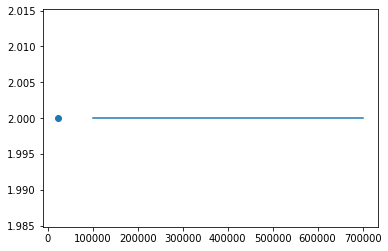

site_id  building_id  square_feet  year_built  floor_count  use_category
285         2          285        21958         NaN          NaN            12
1364       15         1364        74922      1940.0          NaN            12
1425       15         1425         4071      1990.0          NaN            12

285     21958
1364    74922
1425     4071
Name: square_feet, dtype: int32

Series([], Name: floor_count, dtype: float16)

13


0.9307119926732923

(array([2.44615221e-05]), 3.4045869135966225)

array([ 5.85073912,  8.29689133, 10.74304354, 13.18919575, 15.63534796,
       18.08150017, 20.52765238])

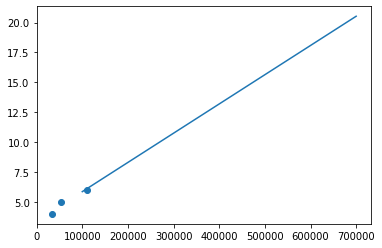

site_id  building_id  square_feet  year_built  floor_count  use_category
1038       12         1038         9838         NaN          NaN            13
1153       13         1153        89456         NaN          NaN            13
1329       15         1329        60100      1912.0          NaN            13

1038     9838
1153    89456
1329    60100
Name: square_feet, dtype: int32

Series([], Name: floor_count, dtype: float16)

14


1.0

(array([2.23914017e-05]), 0.9137259292431709)

array([ 3.1528661 ,  5.39200627,  7.63114644,  9.87028661, 12.10942678,
       14.34856695, 16.58770712])

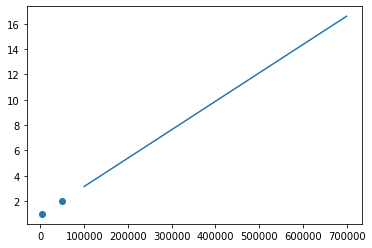

site_id  building_id  square_feet  year_built  floor_count  use_category
1081       13         1081        11470         NaN          NaN            14
1145       13         1145        35201         NaN          NaN            14
1171       13         1171        56851         NaN          NaN            14
1172       13         1172        63847         NaN          NaN            14
1173       13         1173        13091         NaN          NaN            14
1175       13         1175        81372         NaN          NaN            14
1340       15         1340       111518      1968.0          NaN            14
1349       15         1349         7919      1970.0          NaN            14
1436       15         1436        11302      1937.0          NaN            14

1081     11470
1145     35201
1171     56851
1172     63847
1173     13091
1175     81372
1340    111518
1349      7919
1436     11302
Name: square_feet, dtype: int32

Series([], Name: floor_count, dtype: float16)

15


0.5272767781821277

(array([2.51659746e-05]), 2.8016651086538324)

array([ 5.31826257,  7.83486003, 10.3514575 , 12.86805496, 15.38465242,
       17.90124988, 20.41784734])

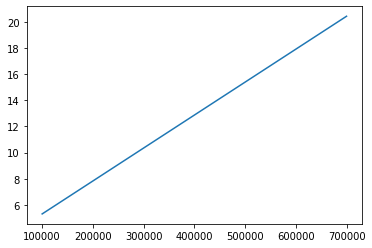

site_id  building_id  square_feet  year_built  floor_count  use_category
892         9          892       481999         NaN          NaN            15
944         9          944       389641         NaN          NaN            15
970         9          970       346056         NaN          NaN            15
982         9          982       373416         NaN          NaN            15
984         9          984       214252         NaN          NaN            15
1115       13         1115        42028         NaN          NaN            15
1116       13         1116        11681         NaN          NaN            15
1118       13         1118        26926         NaN          NaN            15
1120       13         1120        70040         NaN          NaN            15
1197       13         1197        50552         NaN          NaN            15

892     481999
944     389641
970     346056
982     373416
984     214252
1115     42028
1116     11681
1118     26926
1120     70040
1197     50552
Name: square_feet, dtype: int32

Series([], Name: floor_count, dtype: float16)

In [18]:
for use_type in df_building_metadata.use_category.unique():
  print(use_type)
  check_df = df_building_metadata\
  [['use_category','floor_count','square_feet']]\
  .groupby(['use_category','floor_count'],as_index=False)\
  ['square_feet'].mean()\
  .query('use_category==@use_type')

  check_y = check_df.floor_count
  check_X = check_df.square_feet

  plt.scatter(check_X,check_y)

  if len(check_X) == 0:
    check_X = df_building_metadata.query('floor_count == floor_count')['square_feet']
    check_y = df_building_metadata.query('floor_count == floor_count')['floor_count']
  

  reg = LinearRegression().fit(np.array(check_X).reshape(-1, 1),check_y)
  reg.score(np.array(check_X).reshape(-1, 1),check_y)
  reg.coef_, reg.intercept_

  reg.predict(np.array([100000,200000,300000,400000,500000,600000,700000])\
                                          .reshape(-1, 1))

  plt.plot([100000,200000,300000,400000,500000,600000,700000],\
           reg.predict(\
                       np.array([100000,200000,300000,400000,500000,600000,700000])\
                       .reshape(-1, 1)\
                       )\
           )
  plt.show()

  df_building_metadata.query('floor_count != floor_count').query('use_category == @use_type')
  df_building_metadata.query(\
                             'floor_count != floor_count')\
                             .query('use_category == @use_type')\
                             ['square_feet']

  try:
    df_building_metadata.loc[df_building_metadata\
                             .query('floor_count != floor_count')\
                             .query('use_category == @use_type').index.values,\
                             'floor_count'] = \
                             np.around(reg.predict(np.array(\
                                                            df_building_metadata[['use_category','square_feet','floor_count']]\
                                                            .query('floor_count != floor_count')\
                                                            .query('use_category == @use_type')\
                                                            .square_feet)\
                                                   .reshape(-1, 1)\
                                                   )\
                                       )
  except:
    print('Error with use_category: {}'.format(use_type))

  df_building_metadata\
  .query('floor_count != floor_count')\
  .query('use_category == @use_type')['floor_count']

In [19]:
df_building_metadata\
.query('floor_count != floor_count')\
.query('use_category == @use_type')['floor_count']

Series([], Name: floor_count, dtype: float16)

In [20]:
df_building_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id         1449 non-null int8
building_id     1449 non-null int16
square_feet     1449 non-null int32
year_built      675 non-null float16
floor_count     1449 non-null float16
use_category    1449 non-null int8
dtypes: float16(2), int16(1), int32(1), int8(2)
memory usage: 17.1 KB


In [21]:
df_building_metadata.floor_count

0       2.0
1       1.0
2       2.0
3       2.0
4       6.0
       ... 
1444    4.0
1445    2.0
1446    4.0
1447    6.0
1448    7.0
Name: floor_count, Length: 1449, dtype: float16

In [0]:
df_building_metadata['floor_count'] = df_building_metadata['floor_count'].astype('int8')

In [23]:
df_building_metadata.floor_count
df_building_metadata.info()

0       2
1       1
2       2
3       2
4       6
       ..
1444    4
1445    2
1446    4
1447    6
1448    7
Name: floor_count, Length: 1449, dtype: int8

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id         1449 non-null int8
building_id     1449 non-null int16
square_feet     1449 non-null int32
year_built      675 non-null float16
floor_count     1449 non-null int8
use_category    1449 non-null int8
dtypes: float16(1), int16(1), int32(1), int8(3)
memory usage: 15.7 KB


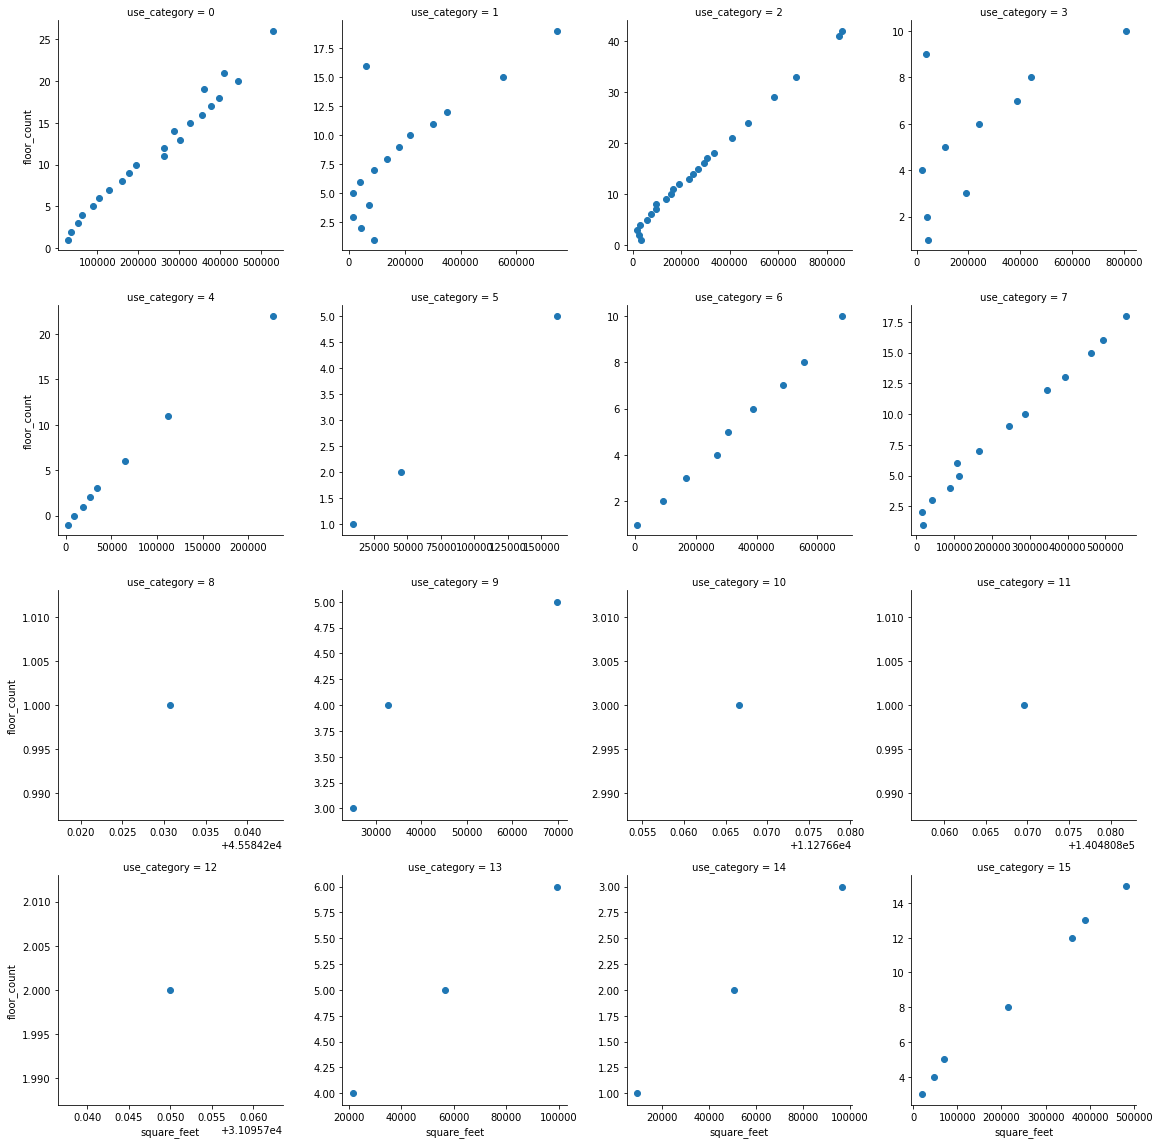

In [24]:
g = sns.FacetGrid(df_building_metadata[['use_category','floor_count','square_feet']].groupby(['use_category','floor_count'],as_index=False)\
['square_feet'].mean(), col='use_category',col_wrap=4,sharey=False,sharex=False,height = 4)
g = (g.map(plt.scatter, 'square_feet','floor_count').add_legend())

In [0]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# Weather Train EDA

In [26]:
df_weather_train = pd.read_csv('weather_train.csv',parse_dates = ['timestamp'], date_parser = dateparse)
df_weather_train.info()
df_weather_train.head()
df_weather_train.tail()
df_weather_train = reduce_mem_usage(df_weather_train)
df_weather_train.info()
df_weather_train['day'] = df_weather_train['timestamp'].dt.day
df_weather_train['week'] = df_weather_train['timestamp'].dt.week
df_weather_train['month'] = df_weather_train['timestamp'].dt.month
df_weather_train['hour'] = df_weather_train['timestamp'].dt.hour
df_weather_train.info()
df_weather_train = reduce_mem_usage(df_weather_train)
df_weather_train.info()
df_weather_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.6 MB


site_id           timestamp  ...  wind_direction  wind_speed
0        0 2016-01-01 00:00:00  ...             0.0         0.0
1        0 2016-01-01 01:00:00  ...            70.0         1.5
2        0 2016-01-01 02:00:00  ...             0.0         0.0
3        0 2016-01-01 03:00:00  ...             0.0         0.0
4        0 2016-01-01 04:00:00  ...           250.0         2.6

[5 rows x 9 columns]

site_id           timestamp  ...  wind_direction  wind_speed
139768       15 2016-12-31 19:00:00  ...           180.0         5.7
139769       15 2016-12-31 20:00:00  ...           180.0         7.7
139770       15 2016-12-31 21:00:00  ...           180.0         5.1
139771       15 2016-12-31 22:00:00  ...           170.0         4.6
139772       15 2016-12-31 23:00:00  ...           180.0         8.8

[5 rows x 9 columns]

Mem. usage decreased to  3.07 Mb (68.1% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int8
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float16
cloud_coverage        70600 non-null float16
dew_temperature       139660 non-null float16
precip_depth_1_hr     89484 non-null float16
sea_level_pressure    129155 non-null float16
wind_direction        133505 non-null float16
wind_speed            139469 non-null float16
dtypes: datetime64[ns](1), float16(7), int8(1)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 13 columns):
site_id               139773 non-null int8
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float16
cloud_coverage        70600 non-null float16
dew_temperature       139660 non-null float16
precip_dept

site_id           timestamp  air_temperature  ...  week  month  hour
0        0 2016-01-01 00:00:00        25.000000  ...    53      1     0
1        0 2016-01-01 01:00:00        24.406250  ...    53      1     1
2        0 2016-01-01 02:00:00        22.796875  ...    53      1     2
3        0 2016-01-01 03:00:00        21.093750  ...    53      1     3
4        0 2016-01-01 04:00:00        20.000000  ...    53      1     4

[5 rows x 13 columns]

In [27]:
print('Missing Values in %:\n{}'.format(100*df_weather_train.isna().sum()/df_weather_train.shape[0]))

Missing Values in %:
site_id                0.000000
timestamp              0.000000
air_temperature        0.039350
cloud_coverage        49.489529
dew_temperature        0.080845
precip_depth_1_hr     35.979052
sea_level_pressure     7.596603
wind_direction         4.484414
wind_speed             0.217496
day                    0.000000
week                   0.000000
month                  0.000000
hour                   0.000000
dtype: float64


In [0]:
weather_metrics = ['air_temperature', 'cloud_coverage','dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure','wind_direction', 'wind_speed']

In [0]:
def fill_missing_column(df,filler_df,col):
    null_df = df.loc[df[col].isnull()]
    
    if null_df.empty != True:
        null_df[col] = null_df.apply(lambda x: filler_df.loc[x['site_id']][x['month']][x['hour']],axis=1)
        df.loc[null_df.index,col] = null_df[col]
    
    return df


In [30]:
for item in weather_metrics:
  filler = df_weather_train.groupby(by = ['site_id','month','hour'])[item].agg(np.mean)

  df_weather_train = fill_missing_column(df_weather_train,filler,item)
print('Missing Values in %:\n{}'.format(100*df_weather_train.isna().sum()/df_weather_train.shape[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Missing Values in %:
site_id                0.000000
timestamp              0.000000
air_temperature        0.000000
cloud_coverage        12.370057
dew_temperature        0.000000
precip_depth_1_hr     20.325099
sea_level_pressure     6.263728
wind_direction         0.000000
wind_speed             0.000000
day                    0.000000
week                   0.000000
month                  0.000000
hour                   0.000000
dtype: float64


In [31]:
df_weather_train.groupby(['site_id'])['air_temperature'].median()

site_id
0     23.906250
1     11.296875
2     25.593750
3     15.601562
4     15.000000
5     11.000000
6     16.093750
7      7.699219
8     23.906250
9     22.203125
10    11.703125
11     7.699219
12     9.796875
13    11.101562
14    13.296875
15     9.398438
Name: air_temperature, dtype: float16

In [32]:
df_weather_train.groupby(['site_id'])['air_temperature','dew_temperature','sea_level_pressure','cloud_coverage','precip_depth_1_hr','wind_direction', 'wind_speed'].median()

air_temperature  dew_temperature  ...  wind_direction  wind_speed
site_id                                    ...                            
0              23.906250        18.296875  ...          140.00    3.099609
1              11.296875         7.800781  ...          220.00    3.599609
2              25.593750         3.300781  ...          130.00    2.599609
3              15.601562         9.398438  ...          190.00    3.599609
4              15.000000        10.601562  ...          260.00    3.599609
5              11.000000         8.000000  ...          240.00    4.601562
6              16.093750         8.898438  ...          149.25    2.099609
7               7.699219         2.400391  ...          230.00    3.099609
8              23.906250        18.296875  ...          140.00    3.099609
9              22.203125        17.203125  ...          120.00    2.099609
10             11.703125         0.600098  ...          170.00    3.099609
11              7.699219         2.400391  ...          230.00    3.099609
12              9.796875         6.699219  ...          230.00    5.000000
13             11.101562         3.900391  ...          180.00    4.101562
14             13.296875         6.101562  ...          210.00    2.599609
15              9.398438         4.398438  ...          180.00    3.099609

[16 rows x 7 columns]

In [33]:
df_weather_train.groupby(['site_id'])['air_temperature','dew_temperature','sea_level_pressure','cloud_coverage','precip_depth_1_hr','wind_direction', 'wind_speed'].mean()

air_temperature  dew_temperature  ...  wind_direction  wind_speed
site_id                                    ...                            
0              22.828125        16.812500  ...         156.500    3.375000
1              11.710938         7.648438  ...         195.625    3.966797
2              24.937500         4.070312  ...         153.625    2.933594
3              15.523438         8.132812  ...         185.000    3.910156
4              15.234375         9.898438  ...         208.000    3.857422
5              10.867188         8.195312  ...         200.000    4.769531
6              15.132812         7.312500  ...         132.750    2.199219
7               7.890625         1.891602  ...         208.875    3.445312
8              22.828125        16.812500  ...         156.500    3.375000
9              21.359375        14.609375  ...         118.000    2.087891
10             11.640625         0.089844  ...         181.375    3.164062
11              7.890625         1.891602  ...         208.875    3.445312
12              9.843750         6.519531  ...         202.750    5.511719
13              9.875000         3.400391  ...         188.125    4.199219
14             13.257812         5.777344  ...         187.875    3.078125
15              9.359375         4.144531  ...         187.500    3.644531

[16 rows x 7 columns]

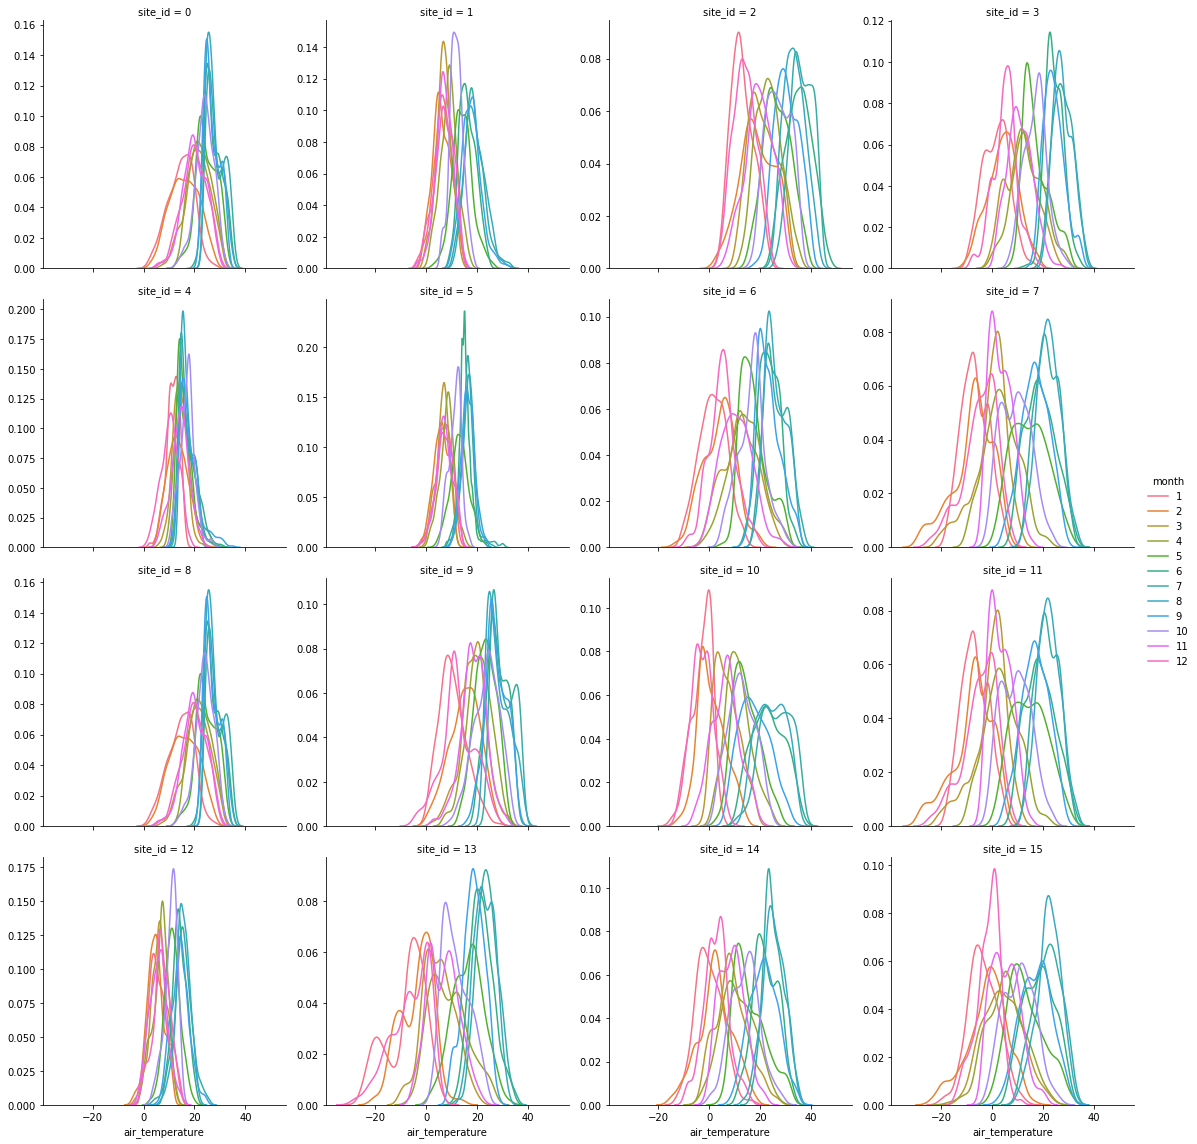

In [34]:
g = sns.FacetGrid(df_weather_train, col = 'site_id', hue='month', col_wrap = 4, sharey=False,sharex=True,height = 4)
g = (g.map(sns.kdeplot, 'air_temperature').add_legend())

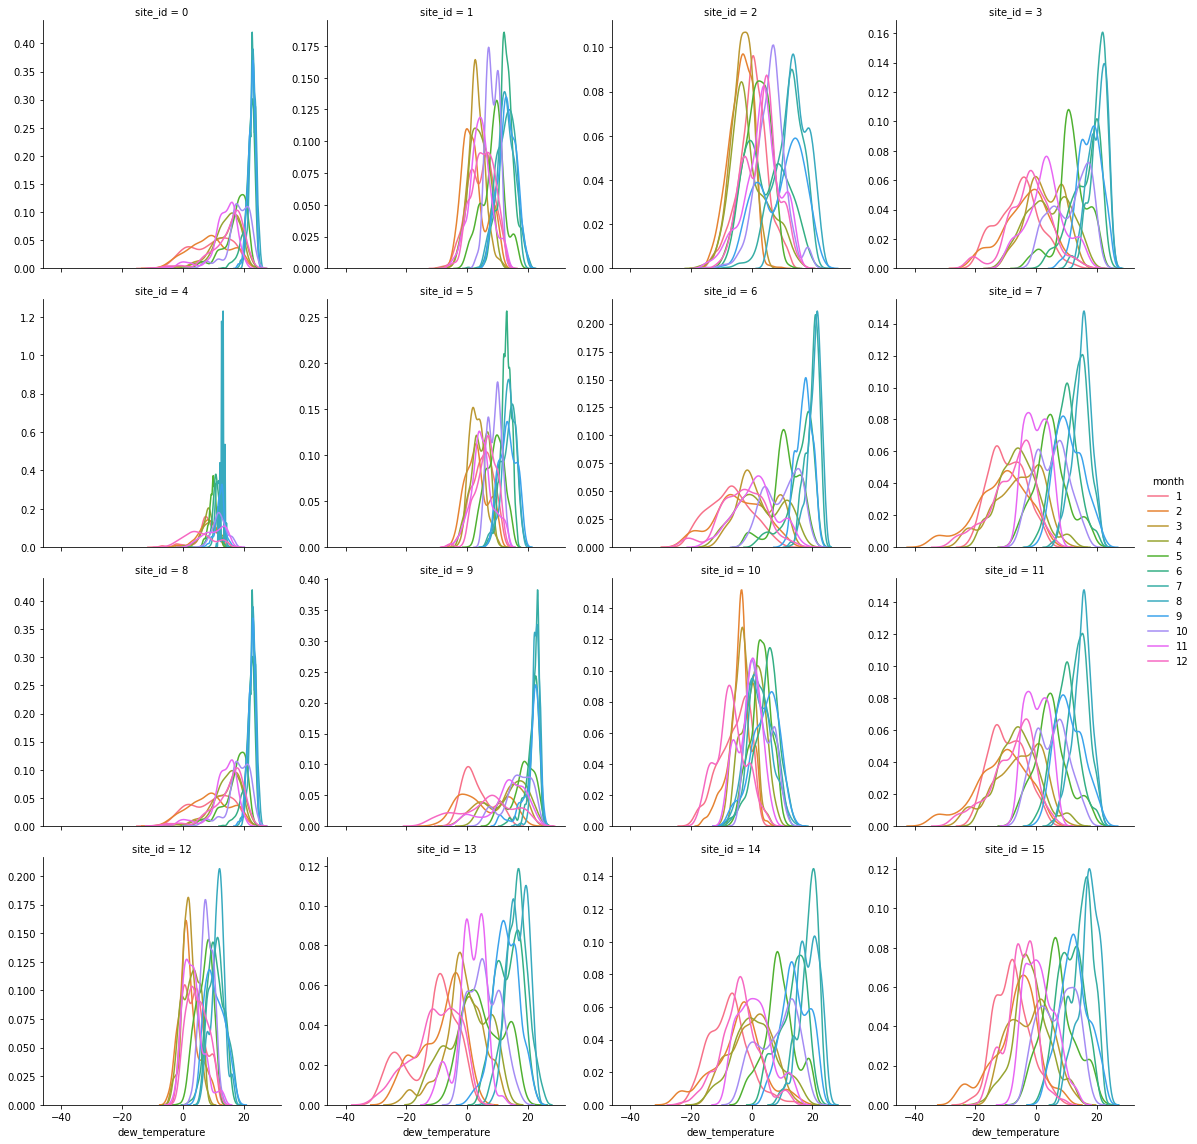

In [35]:
g = sns.FacetGrid(df_weather_train, col = 'site_id', hue='month', col_wrap = 4, sharey=False,sharex=True,height = 4)
g = (g.map(sns.kdeplot, 'dew_temperature').add_legend())

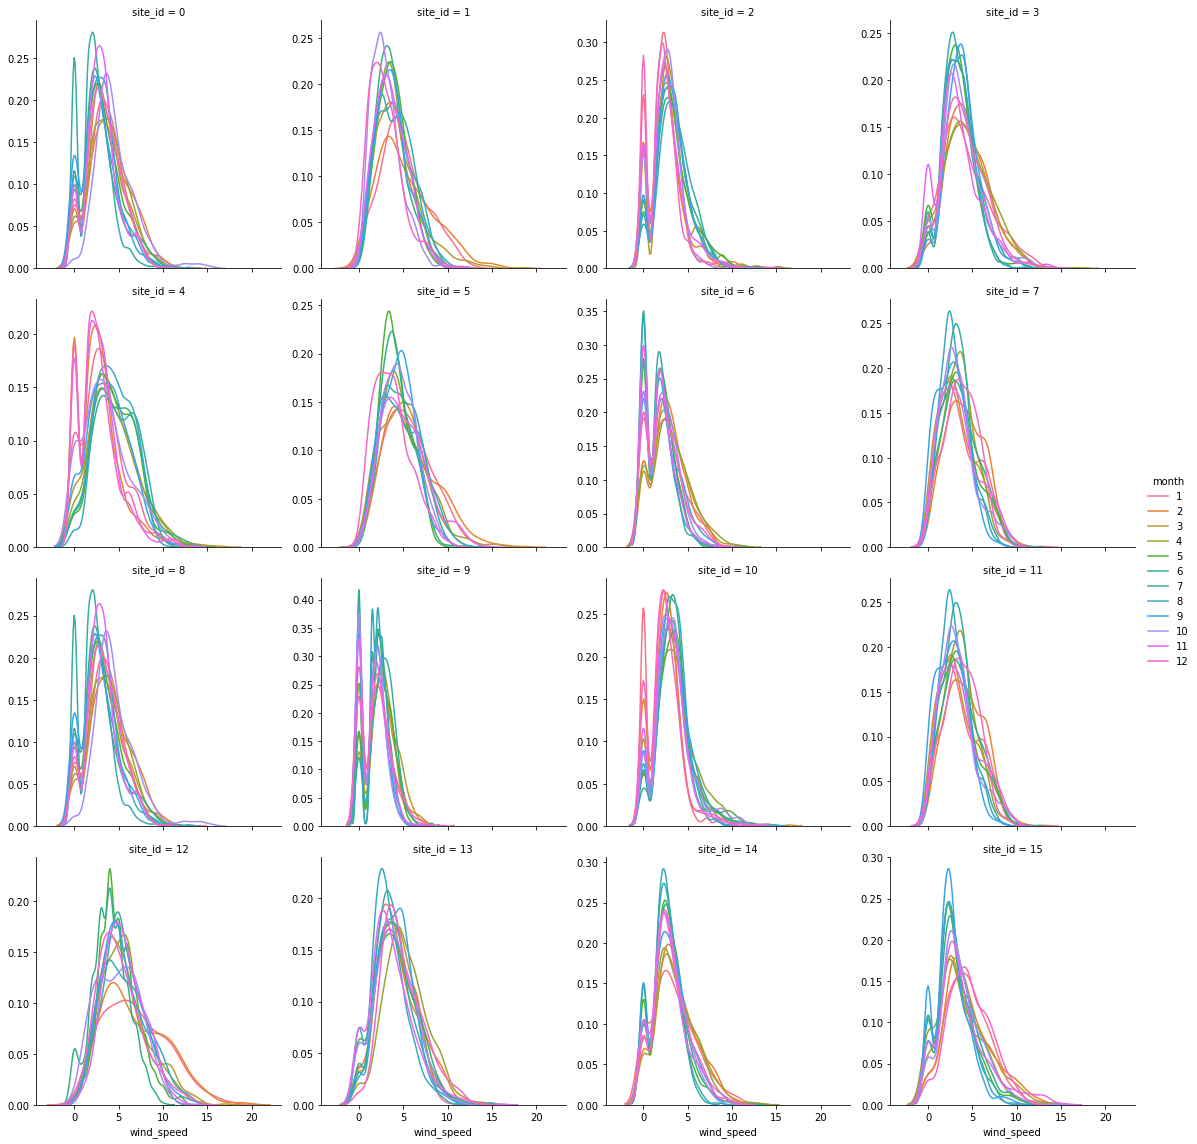

In [36]:
g = sns.FacetGrid(df_weather_train, col = 'site_id', hue='month', col_wrap = 4, sharey=False,sharex=True,height = 4)
g = (g.map(sns.kdeplot, 'wind_speed').add_legend())

In [37]:
%env

{'CLICOLOR': '1',
 'CLOUDSDK_CONFIG': '/content/.config',
 'COLAB_GPU': '1',
 'CUDA_PKG_VERSION': '10-0=10.0.130-1',
 'CUDA_VERSION': '10.0.130',
 'CUDNN_VERSION': '7.6.3.30',
 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\\"172.28.0.2\\""]}',
 'DEBIAN_FRONTEND': 'noninteractive',
 'ENV': '/root/.bashrc',
 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16',
 'GIT_PAGER': 'cat',
 'GLIBCPP_FORCE_NEW': '1',
 'GLIBCXX_FORCE_NEW': '1',
 'HOME': '/root',
 'HOSTNAME': '13f25fc3d877',
 'JPY_PARENT_PID': '23',
 'KMP_DUPLICATE_LIB_OK': 'True',
 'KMP_INIT_AT_FORK': 'FALSE',
 'LANG': 'en_US.UTF-8',
 'LAST_FORCED_REBUILD': '20191018',
 'LD_LIBRARY_PATH': '/usr/lib64-nvidia',
 'LD_PRELOAD': '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4',
 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs',
 'MPLBACKEND': 'module://ipykernel.pylab.backend_inline',
 'NCCL_VERSION': '2.4.8',
 'NO_GCE_CHECK': 'True',
 'NVIDIA_DRIVER_CAPABILITIES': 'compute,utility',

In [38]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df_weather_train', 3774023),
 ('filler', 24307),
 ('check_X', 17292),
 ('df_building_metadata', 16091),
 ('check_y', 14414),
 ('LinearRegression', 1184),
 ('InteractiveShell', 1056),
 ('primary_use_map', 648),
 ('dateparse', 136),
 ('fill_missing_column', 136),
 ('reduce_mem_usage', 136),
 ('weather_metrics', 120),
 ('item', 103),
 ('drive', 80),
 ('lgb', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('g', 56),
 ('reg', 56),
 ('use_type', 32),
 ('check_df', 24)]

https://www.kaggle.com/datadugong/locate-better-cities-by-weather-temp-fill-nans

	location	corr
site_id		
0	orlando	0.971346
1	heathrow	0.985568
2	Phoenix	0.978950
3	washington	0.990834
4	San Francisco	0.927506
5	birmingham	0.944360
6	washington	0.976488
7	ottowa	0.990955
8	orlando	0.971346
9	sanantonio	0.978205
10	saltlake	0.974286
11	ottowa	0.990955
12	dublin	0.954968
13	Minneapolis	0.994499
14	Philadelphia	0.993035
15	rochester	0.975049




In [39]:
df_weather_train.cloud_coverage.fillna(value=0, inplace=True)
df_weather_train.precip_depth_1_hr.fillna(value=0, inplace=True)
df_weather_train.sea_level_pressure.fillna(value=1015, inplace=True)

df_weather_train.isna().sum()
df_weather_train.groupby(['site_id'])['air_temperature','dew_temperature','sea_level_pressure','cloud_coverage','precip_depth_1_hr','wind_direction', 'wind_speed'].mean()

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
day                   0
week                  0
month                 0
hour                  0
dtype: int64

air_temperature  dew_temperature  ...  wind_direction  wind_speed
site_id                                    ...                            
0              22.828125        16.812500  ...         156.500    3.375000
1              11.710938         7.648438  ...         195.625    3.966797
2              24.937500         4.070312  ...         153.625    2.933594
3              15.523438         8.132812  ...         185.000    3.910156
4              15.234375         9.898438  ...         208.000    3.857422
5              10.867188         8.195312  ...         200.000    4.769531
6              15.132812         7.312500  ...         132.750    2.199219
7               7.890625         1.891602  ...         208.875    3.445312
8              22.828125        16.812500  ...         156.500    3.375000
9              21.359375        14.609375  ...         118.000    2.087891
10             11.640625         0.089844  ...         181.375    3.164062
11              7.890625         1.891602  ...         208.875    3.445312
12              9.843750         6.519531  ...         202.750    5.511719
13              9.875000         3.400391  ...         188.125    4.199219
14             13.257812         5.777344  ...         187.875    3.078125
15              9.359375         4.144531  ...         187.500    3.644531

[16 rows x 7 columns]

# Train Data Manip

In [40]:
df_train = pd.read_csv('train.csv',parse_dates = ['timestamp'], date_parser = dateparse)
df_train.info()
df_train.head()
df_train = reduce_mem_usage(df_train)
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        datetime64[ns]
meter_reading    float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 616.9 MB


building_id  meter  timestamp  meter_reading
0            0      0 2016-01-01            0.0
1            1      0 2016-01-01            0.0
2            2      0 2016-01-01            0.0
3            3      0 2016-01-01            0.0
4            4      0 2016-01-01            0.0

Mem. usage decreased to 289.19 Mb (53.1% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int16
meter            int8
timestamp        datetime64[ns]
meter_reading    float32
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB


building_id  meter  timestamp  meter_reading
0            0      0 2016-01-01            0.0
1            1      0 2016-01-01            0.0
2            2      0 2016-01-01            0.0
3            3      0 2016-01-01            0.0
4            4      0 2016-01-01            0.0

In [41]:
df_train = df_train.merge(df_building_metadata,on='building_id')
df_train.info()
df_train = reduce_mem_usage(df_train)
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 9 columns):
building_id      int16
meter            int8
timestamp        datetime64[ns]
meter_reading    float32
site_id          int8
square_feet      int32
year_built       float16
floor_count      int8
use_category     int8
dtypes: datetime64[ns](1), float16(1), float32(1), int16(1), int32(1), int8(4)
memory usage: 616.9 MB
Mem. usage decreased to 616.95 Mb (0.0% reduction)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 9 columns):
building_id      int16
meter            int8
timestamp        datetime64[ns]
meter_reading    float32
site_id          int8
square_feet      int32
year_built       float16
floor_count      int8
use_category     int8
dtypes: datetime64[ns](1), float16(1), float32(1), int16(1), int32(1), int8(4)
memory usage: 616.9 MB


building_id  meter  ... floor_count  use_category
0            0      0  ...           2             0
1            0      0  ...           2             0
2            0      0  ...           2             0
3            0      0  ...           2             0
4            0      0  ...           2             0

[5 rows x 9 columns]

In [42]:
df_train['building_age'] = df_train['timestamp'].dt.year-df_train['year_built']
df_train.drop(columns=['year_built'],inplace=True)
df_train.info()
df_train = reduce_mem_usage(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 9 columns):
building_id      int16
meter            int8
timestamp        datetime64[ns]
meter_reading    float32
site_id          int8
square_feet      int32
floor_count      int8
use_category     int8
building_age     float64
dtypes: datetime64[ns](1), float32(1), float64(1), int16(1), int32(1), int8(4)
memory usage: 732.6 MB
Mem. usage decreased to 616.95 Mb (15.8% reduction)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 9 columns):
building_id      int16
meter            int8
timestamp        datetime64[ns]
meter_reading    float32
site_id          int8
square_feet      int32
floor_count      int8
use_category     int8
building_age     float16
dtypes: datetime64[ns](1), float16(1), float32(1), int16(1), int32(1), int8(4)
memory usage: 616.9 MB


In [43]:
df_train = df_train.merge(df_weather_train,on=['site_id','timestamp'])
df_train.info()
df_train = reduce_mem_usage(df_train)
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20125605 entries, 0 to 20125604
Data columns (total 20 columns):
building_id           int16
meter                 int8
timestamp             datetime64[ns]
meter_reading         float32
site_id               int8
square_feet           int32
floor_count           int8
use_category          int8
building_age          float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
day                   int8
week                  int8
month                 int8
hour                  int8
dtypes: datetime64[ns](1), float16(8), float32(1), int16(1), int32(1), int8(8)
memory usage: 959.7 MB
Mem. usage decreased to 959.66 Mb (0.0% reduction)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20125605 entries, 0 to 20125604
Data columns (total 20 columns):
building_id           int16
meter     

building_id  meter  timestamp  meter_reading  ...  day  week  month  hour
0            0      0 2016-01-01            0.0  ...    1    53      1     0
1            1      0 2016-01-01            0.0  ...    1    53      1     0
2            2      0 2016-01-01            0.0  ...    1    53      1     0
3            3      0 2016-01-01            0.0  ...    1    53      1     0
4            4      0 2016-01-01            0.0  ...    1    53      1     0

[5 rows x 20 columns]

In [44]:
df_train.isna().sum()

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
square_feet                  0
floor_count                  0
use_category                 0
building_age          12113306
air_temperature              0
cloud_coverage               0
dew_temperature              0
precip_depth_1_hr            0
sea_level_pressure           0
wind_direction               0
wind_speed                   0
day                          0
week                         0
month                        0
hour                         0
dtype: int64

In [45]:
df_train.drop(columns=['timestamp','building_age'],inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20125605 entries, 0 to 20125604
Data columns (total 18 columns):
building_id           int16
meter                 int8
meter_reading         float32
site_id               int8
square_feet           int32
floor_count           int8
use_category          int8
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
day                   int8
week                  int8
month                 int8
hour                  int8
dtypes: float16(7), float32(1), int16(1), int32(1), int8(8)
memory usage: 767.7 MB


In [46]:
df_train['log_meter_reading'] = np.log1p(df_train['meter_reading'])
df_train.drop(columns=['meter_reading'],inplace=True) 

df_train.info()
df_train = reduce_mem_usage(df_train)
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20125605 entries, 0 to 20125604
Data columns (total 18 columns):
building_id           int16
meter                 int8
site_id               int8
square_feet           int32
floor_count           int8
use_category          int8
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
day                   int8
week                  int8
month                 int8
hour                  int8
log_meter_reading     float32
dtypes: float16(7), float32(1), int16(1), int32(1), int8(8)
memory usage: 767.7 MB
Mem. usage decreased to 729.34 Mb (5.0% reduction)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20125605 entries, 0 to 20125604
Data columns (total 18 columns):
building_id           int16
meter                 int8
site_id               int8
square_feet           int32
floor_count   

building_id  meter  site_id  ...  month  hour  log_meter_reading
0            0      0        0  ...      1     0                0.0
1            1      0        0  ...      1     0                0.0
2            2      0        0  ...      1     0                0.0
3            3      0        0  ...      1     0                0.0
4            4      0        0  ...      1     0                0.0

[5 rows x 18 columns]

In [47]:
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df_train', 764773014),
 ('df_weather_train', 3774023),
 ('filler', 24307),
 ('check_X', 17292),
 ('df_building_metadata', 16091),
 ('check_y', 14414),
 ('LinearRegression', 1184),
 ('InteractiveShell', 1056),
 ('primary_use_map', 648),
 ('dateparse', 136),
 ('fill_missing_column', 136),
 ('reduce_mem_usage', 136),
 ('weather_metrics', 120),
 ('item', 103),
 ('drive', 80),
 ('lgb', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('g', 56),
 ('reg', 56),
 ('use_type', 32),
 ('check_df', 24)]

In [48]:
X_train = df_train.drop(columns = ['log_meter_reading','cloud_coverage',	'dew_temperature',	'precip_depth_1_hr',	'sea_level_pressure',	'wind_direction',	'wind_speed'])

y_train = df_train.log_meter_reading
X_train.shape, y_train.shape
type(X_train)
type(y_train)

((20125605, 11), (20125605,))

pandas.core.frame.DataFrame

pandas.core.series.Series

In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20125605 entries, 0 to 20125604
Data columns (total 18 columns):
building_id           int16
meter                 int8
site_id               int8
square_feet           int32
floor_count           int8
use_category          int8
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
day                   int8
week                  int8
month                 int8
hour                  int8
log_meter_reading     float16
dtypes: float16(8), int16(1), int32(1), int8(8)
memory usage: 729.3 MB


# LGB Model

In [0]:
X_half_1 = X_train[:int(X_train.shape[0] / 2)]
X_half_2 = X_train[int(X_train.shape[0] / 2):]

y_half_1 = y_train[:int(X_train.shape[0] / 2)]
y_half_2 = y_train[int(X_train.shape[0] / 2):]

categorical_features = ['building_id', 'site_id', 'meter', 'use_category', 'day', 'week', 'month', 'hour' ]

In [0]:
d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

In [52]:
print("Building model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=1000, valid_sets=watchlist_1, verbose_eval=200, early_stopping_rounds=200)

print("Building model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=1000, valid_sets=watchlist_2, verbose_eval=200, early_stopping_rounds=200)

Building model with first half and validating on second half:


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.716697	valid_1's rmse: 2.2019
Early stopping, best iteration is:
[99]	training's rmse: 0.816706	valid_1's rmse: 2.17545
Building model with second half and validating on first half:
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 1.37848	valid_1's rmse: 1.78256
Early stopping, best iteration is:
[84]	training's rmse: 1.51942	valid_1's rmse: 1.76442


In [53]:
del df_train, X_train, X_half_1, X_half_2, y_train, y_half_1, y_half_2
gc.collect()

471

# Weather Test EDA

In [54]:
df_weather_test = pd.read_csv('weather_test.csv',parse_dates = ['timestamp'], date_parser = dateparse)
df_weather_test.info()
df_weather_test.head()
df_weather_test.tail()
df_weather_test = reduce_mem_usage(df_weather_test)
df_weather_test.info()
df_weather_test['day'] = df_weather_test['timestamp'].dt.day
df_weather_test['week'] = df_weather_test['timestamp'].dt.week
df_weather_test['month'] = df_weather_test['timestamp'].dt.month
df_weather_test['hour'] = df_weather_test['timestamp'].dt.hour
df_weather_test.info()
df_weather_test = reduce_mem_usage(df_weather_test)
df_weather_test.info()
df_weather_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
site_id               277243 non-null int64
timestamp             277243 non-null datetime64[ns]
air_temperature       277139 non-null float64
cloud_coverage        136795 non-null float64
dew_temperature       276916 non-null float64
precip_depth_1_hr     181655 non-null float64
sea_level_pressure    255978 non-null float64
wind_direction        264873 non-null float64
wind_speed            276783 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 19.0 MB


site_id           timestamp  ...  wind_direction  wind_speed
0        0 2017-01-01 00:00:00  ...           100.0         3.6
1        0 2017-01-01 01:00:00  ...           130.0         3.1
2        0 2017-01-01 02:00:00  ...           140.0         3.1
3        0 2017-01-01 03:00:00  ...           140.0         3.1
4        0 2017-01-01 04:00:00  ...           130.0         2.6

[5 rows x 9 columns]

site_id           timestamp  ...  wind_direction  wind_speed
277238       15 2018-12-31 19:00:00  ...           150.0         7.7
277239       15 2018-12-31 20:00:00  ...           140.0         5.1
277240       15 2018-12-31 21:00:00  ...           140.0         6.2
277241       15 2018-12-31 22:00:00  ...           140.0         5.1
277242       15 2018-12-31 23:00:00  ...           140.0         5.1

[5 rows x 9 columns]

Mem. usage decreased to  6.08 Mb (68.1% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
site_id               277243 non-null int8
timestamp             277243 non-null datetime64[ns]
air_temperature       277139 non-null float16
cloud_coverage        136795 non-null float16
dew_temperature       276916 non-null float16
precip_depth_1_hr     181655 non-null float16
sea_level_pressure    255978 non-null float16
wind_direction        264873 non-null float16
wind_speed            276783 non-null float16
dtypes: datetime64[ns](1), float16(7), int8(1)
memory usage: 6.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 13 columns):
site_id               277243 non-null int8
timestamp             277243 non-null datetime64[ns]
air_temperature       277139 non-null float16
cloud_coverage        136795 non-null float16
dew_temperature       276916 non-null float16
precip_d

site_id           timestamp  air_temperature  ...  week  month  hour
0        0 2017-01-01 00:00:00        17.796875  ...    52      1     0
1        0 2017-01-01 01:00:00        17.796875  ...    52      1     1
2        0 2017-01-01 02:00:00        16.093750  ...    52      1     2
3        0 2017-01-01 03:00:00        17.203125  ...    52      1     3
4        0 2017-01-01 04:00:00        16.703125  ...    52      1     4

[5 rows x 13 columns]

In [55]:
print('Missing Values in %:\n{}'.format(100*df_weather_test.isna().sum()/df_weather_test.shape[0]))

Missing Values in %:
site_id                0.000000
timestamp              0.000000
air_temperature        0.037512
cloud_coverage        50.658808
dew_temperature        0.117947
precip_depth_1_hr     34.478057
sea_level_pressure     7.670167
wind_direction         4.461790
wind_speed             0.165919
day                    0.000000
week                   0.000000
month                  0.000000
hour                   0.000000
dtype: float64


In [56]:
for item in weather_metrics:
  filler = df_weather_test.groupby(by = ['site_id','month','hour'])[item].agg(np.mean)

  df_weather_test = fill_missing_column(df_weather_test,filler,item)
print('Missing Values in %:\n{}'.format(100*df_weather_test.isna().sum()/df_weather_test.shape[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Missing Values in %:
site_id                0.000000
timestamp              0.000000
air_temperature        0.000000
cloud_coverage        11.955577
dew_temperature        0.000000
precip_depth_1_hr     18.900748
sea_level_pressure     6.218732
wind_direction         0.000000
wind_speed             0.000000
day                    0.000000
week                   0.000000
month                  0.000000
hour                   0.000000
dtype: float64


In [57]:
df_weather_test.groupby(['site_id'])['air_temperature'].median()

site_id
0     23.906250
1     11.796875
2     25.000000
3     16.093750
4     14.398438
5     11.000000
6     16.093750
7      7.699219
8     23.906250
9     22.796875
10    10.601562
11     7.699219
12    10.101562
13     8.898438
14    13.296875
15     9.398438
Name: air_temperature, dtype: float16

In [58]:
df_weather_test.groupby(['site_id'])['air_temperature','dew_temperature','sea_level_pressure','cloud_coverage','precip_depth_1_hr','wind_direction', 'wind_speed'].median()
df_weather_test.groupby(['site_id'])['air_temperature','dew_temperature','sea_level_pressure','cloud_coverage','precip_depth_1_hr','wind_direction', 'wind_speed'].mean()

air_temperature  dew_temperature  ...  wind_direction  wind_speed
site_id                                    ...                            
0              23.906250        19.406250  ...         136.750    3.099609
1              11.796875         8.000000  ...         220.000    3.599609
2              25.000000         2.800781  ...         132.000    2.599609
3              16.093750        10.000000  ...         190.000    3.599609
4              14.398438        10.601562  ...         260.000    3.599609
5              11.000000         9.000000  ...         250.000    4.601562
6              16.093750        10.000000  ...         140.000    2.099609
7               7.699219         2.599609  ...         220.000    3.099609
8              23.906250        19.406250  ...         136.750    3.099609
9              22.796875        16.703125  ...         133.500    2.099609
10             10.601562        -0.600098  ...         180.000    3.099609
11              7.699219         2.599609  ...         220.000    3.099609
12             10.101562         7.101562  ...         230.000    5.000000
13              8.898438         2.199219  ...         183.125    3.599609
14             13.296875         7.800781  ...         210.000    3.099609
15              9.398438         5.601562  ...         180.000    3.099609

[16 rows x 7 columns]

air_temperature  dew_temperature  ...  wind_direction  wind_speed
site_id                                    ...                            
0              22.703125        17.656250  ...         150.750    3.400391
1              12.171875         7.542969  ...         198.875    4.039062
2              24.968750         3.816406  ...         155.125    2.882812
3              15.492188         8.367188  ...         184.000    3.902344
4              14.468750         9.804688  ...         204.375    3.753906
5              11.156250         8.437500  ...         209.875    4.886719
6              15.234375         7.867188  ...         128.625    2.257812
7               7.406250         2.109375  ...         206.000    3.361328
8              22.703125        17.656250  ...         150.750    3.400391
9              21.296875        13.437500  ...         128.875    2.199219
10             11.734375        -0.498047  ...         184.500    3.074219
11              7.406250         2.109375  ...         206.000    3.361328
12             10.015625         6.781250  ...         209.375    5.484375
13              8.734375         2.554688  ...         187.000    4.070312
14             13.039062         6.832031  ...         183.375    3.113281
15              8.945312         4.695312  ...         187.250    3.607422

[16 rows x 7 columns]

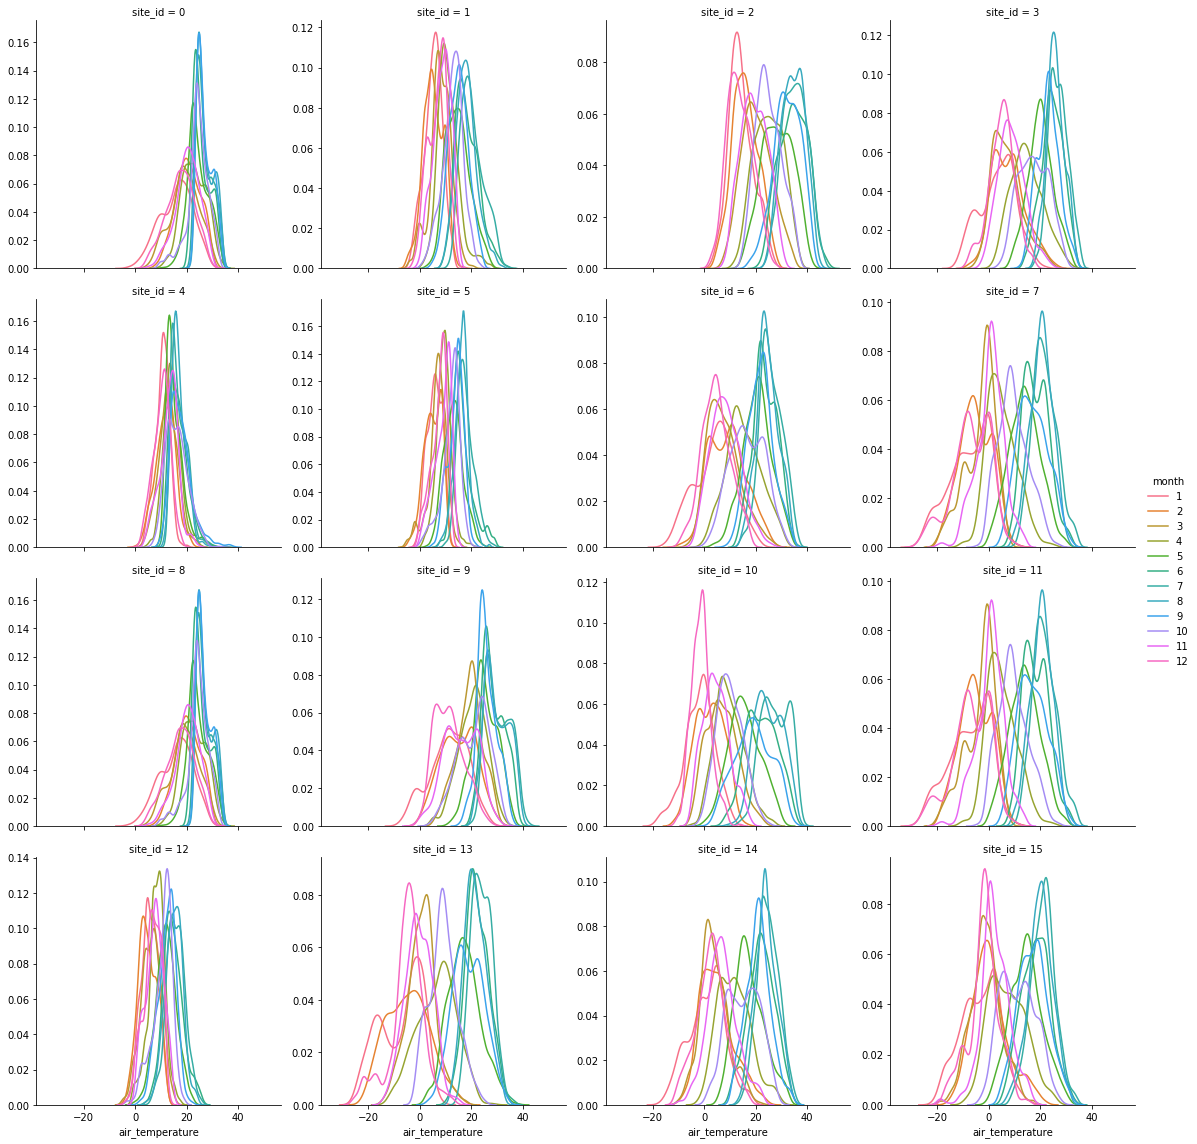

In [59]:
g = sns.FacetGrid(df_weather_test, col = 'site_id', hue='month', col_wrap = 4, sharey=False,sharex=True,height = 4)
g = (g.map(sns.kdeplot, 'air_temperature').add_legend())

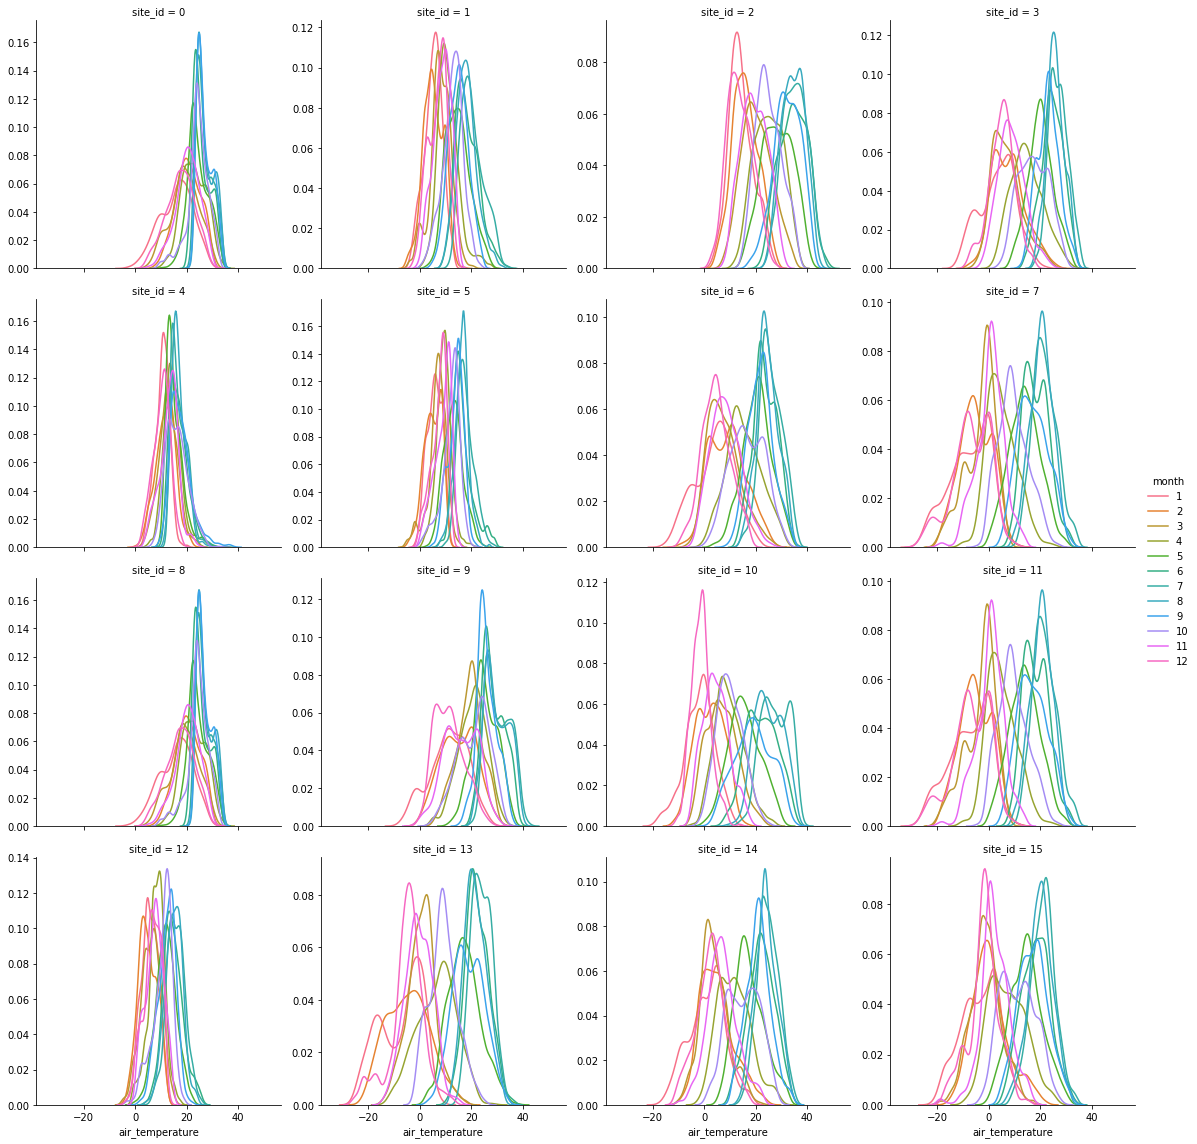

In [60]:
g = sns.FacetGrid(df_weather_test, col = 'site_id', hue='month', col_wrap = 4, sharey=False,sharex=True,height = 4)
g = (g.map(sns.kdeplot, 'air_temperature').add_legend())

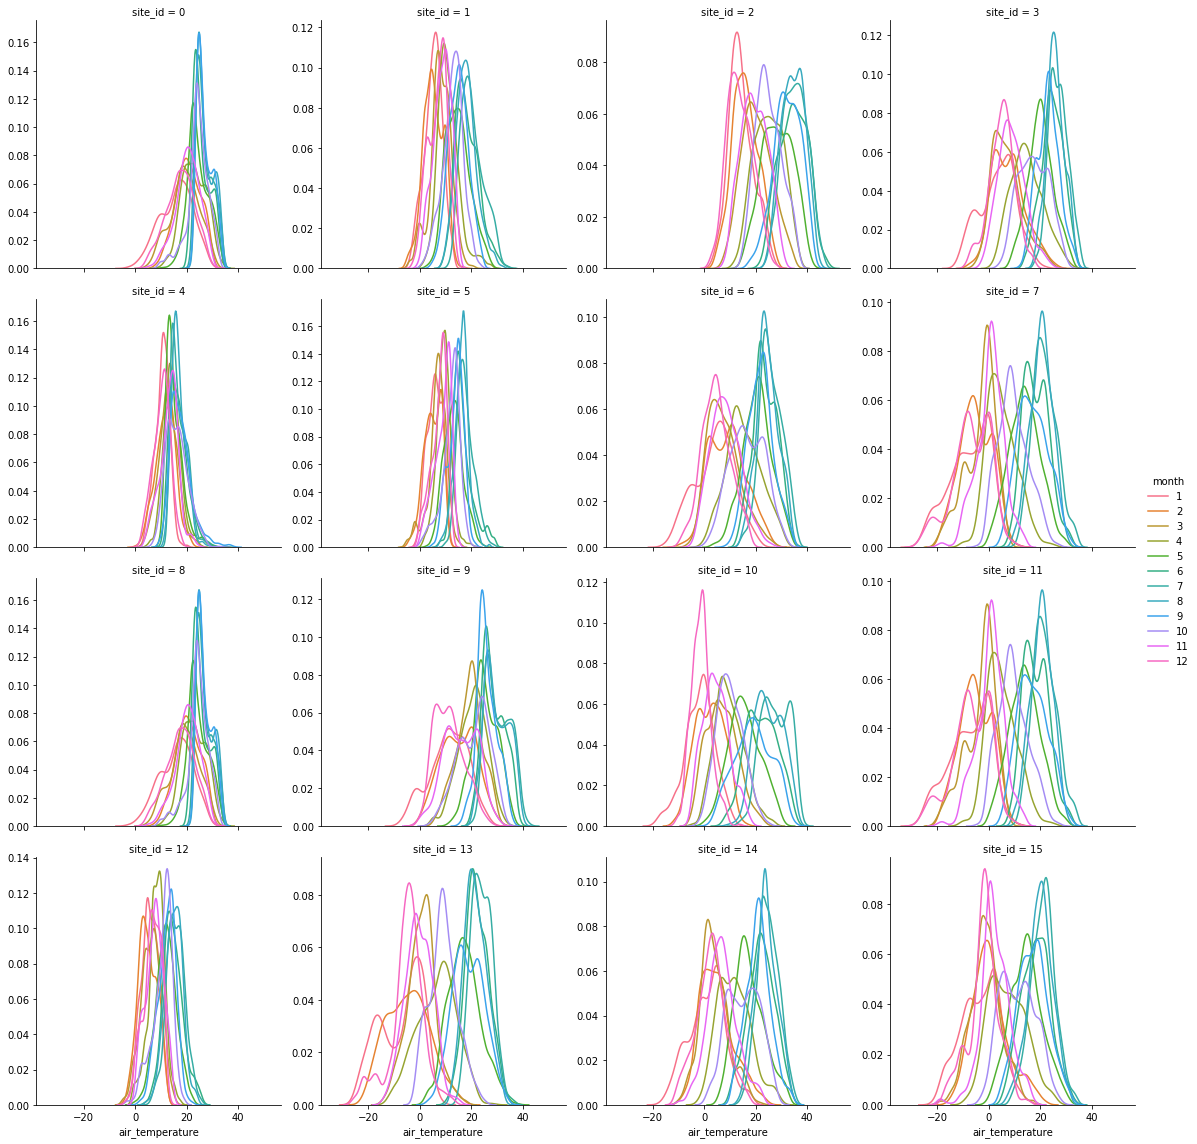

In [61]:
g = sns.FacetGrid(df_weather_test, col = 'site_id', hue='month', col_wrap = 4, sharey=False,sharex=True,height = 4)
g = (g.map(sns.kdeplot, 'air_temperature').add_legend())

In [62]:
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df_weather_test', 7485713),
 ('df_weather_train', 3774023),
 ('filler', 24307),
 ('check_X', 17292),
 ('df_building_metadata', 16091),
 ('check_y', 14414),
 ('LinearRegression', 1184),
 ('InteractiveShell', 1056),
 ('primary_use_map', 648),
 ('params', 368),
 ('dateparse', 136),
 ('fill_missing_column', 136),
 ('reduce_mem_usage', 136),
 ('categorical_features', 128),
 ('weather_metrics', 120),
 ('item', 103),
 ('drive', 80),
 ('lgb', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('watchlist_1', 80),
 ('watchlist_2', 80),
 ('d_half_1', 56),
 ('d_half_2', 56),
 ('g', 56),
 ('model_half_1', 56),
 ('model_half_2', 56),
 ('reg', 56),
 ('use_type', 32),
 ('check_df', 24)]

In [63]:
df_weather_test.cloud_coverage.fillna(value=0, inplace=True)
df_weather_test.precip_depth_1_hr.fillna(value=0, inplace=True)
df_weather_test.sea_level_pressure.fillna(value=1015, inplace=True)

df_weather_test.isna().sum()
df_weather_test.groupby(['site_id'])['air_temperature','dew_temperature','sea_level_pressure','cloud_coverage','precip_depth_1_hr','wind_direction', 'wind_speed'].mean()

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
day                   0
week                  0
month                 0
hour                  0
dtype: int64

air_temperature  dew_temperature  ...  wind_direction  wind_speed
site_id                                    ...                            
0              22.703125        17.656250  ...         150.750    3.400391
1              12.171875         7.542969  ...         198.875    4.039062
2              24.968750         3.816406  ...         155.125    2.882812
3              15.492188         8.367188  ...         184.000    3.902344
4              14.468750         9.804688  ...         204.375    3.753906
5              11.156250         8.437500  ...         209.875    4.886719
6              15.234375         7.867188  ...         128.625    2.257812
7               7.406250         2.109375  ...         206.000    3.361328
8              22.703125        17.656250  ...         150.750    3.400391
9              21.296875        13.437500  ...         128.875    2.199219
10             11.734375        -0.498047  ...         184.500    3.074219
11              7.406250         2.109375  ...         206.000    3.361328
12             10.015625         6.781250  ...         209.375    5.484375
13              8.734375         2.554688  ...         187.000    4.070312
14             13.039062         6.832031  ...         183.375    3.113281
15              8.945312         4.695312  ...         187.250    3.607422

[16 rows x 7 columns]

# Test Data Manip

In [64]:
df_test = pd.read_csv('test.csv',parse_dates = ['timestamp'], date_parser = dateparse)
df_test.info()
df_test.head()
df_test = reduce_mem_usage(df_test)
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
row_id         int64
building_id    int64
meter          int64
timestamp      datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.2 GB


row_id  building_id  meter  timestamp
0       0            0      0 2017-01-01
1       1            1      0 2017-01-01
2       2            2      0 2017-01-01
3       3            3      0 2017-01-01
4       4            4      0 2017-01-01

Mem. usage decreased to 596.49 Mb (53.1% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
row_id         int32
building_id    int16
meter          int8
timestamp      datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(1), int8(1)
memory usage: 596.5 MB


row_id  building_id  meter  timestamp
0       0            0      0 2017-01-01
1       1            1      0 2017-01-01
2       2            2      0 2017-01-01
3       3            3      0 2017-01-01
4       4            4      0 2017-01-01

In [65]:
df_test = df_test.merge(df_building_metadata,on='building_id')
df_test.info()
df_test = reduce_mem_usage(df_test)
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 9 columns):
row_id          int32
building_id     int16
meter           int8
timestamp       datetime64[ns]
site_id         int8
square_feet     int32
year_built      float16
floor_count     int8
use_category    int8
dtypes: datetime64[ns](1), float16(1), int16(1), int32(2), int8(4)
memory usage: 1.2 GB
Mem. usage decreased to 1272.51 Mb (0.0% reduction)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 9 columns):
row_id          int32
building_id     int16
meter           int8
timestamp       datetime64[ns]
site_id         int8
square_feet     int32
year_built      float16
floor_count     int8
use_category    int8
dtypes: datetime64[ns](1), float16(1), int16(1), int32(2), int8(4)
memory usage: 1.2 GB


row_id  building_id  meter  ... year_built  floor_count  use_category
0       0            0      0  ...     2008.0            2             0
1     129            0      0  ...     2008.0            2             0
2     258            0      0  ...     2008.0            2             0
3     387            0      0  ...     2008.0            2             0
4     516            0      0  ...     2008.0            2             0

[5 rows x 9 columns]

In [66]:
df_test['building_age'] = df_test['timestamp'].dt.year-df_test['year_built']
df_test.drop(columns=['year_built'],inplace=True)
df_test.info()
df_test = reduce_mem_usage(df_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 9 columns):
row_id          int32
building_id     int16
meter           int8
timestamp       datetime64[ns]
site_id         int8
square_feet     int32
floor_count     int8
use_category    int8
building_age    float64
dtypes: datetime64[ns](1), float64(1), int16(1), int32(2), int8(4)
memory usage: 1.5 GB
Mem. usage decreased to 1272.51 Mb (15.8% reduction)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 9 columns):
row_id          int32
building_id     int16
meter           int8
timestamp       datetime64[ns]
site_id         int8
square_feet     int32
floor_count     int8
use_category    int8
building_age    float16
dtypes: datetime64[ns](1), float16(1), int16(1), int32(2), int8(4)
memory usage: 1.2 GB


In [68]:
df_test = df_test.merge(df_weather_test,on=['site_id','timestamp'],how='left')

                      
df_test.info()
df_test = reduce_mem_usage(df_test)
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 31 columns):
row_id                  int32
building_id             int16
meter                   int8
timestamp               datetime64[ns]
site_id                 int8
square_feet             int32
floor_count             int8
use_category            int8
building_age            float16
air_temperature_x       float16
cloud_coverage_x        float16
dew_temperature_x       float16
precip_depth_1_hr_x     float16
sea_level_pressure_x    float16
wind_direction_x        float16
wind_speed_x            float16
day_x                   float64
week_x                  float64
month_x                 float64
hour_x                  float64
air_temperature_y       float16
cloud_coverage_y        float16
dew_temperature_y       float16
precip_depth_1_hr_y     float16
sea_level_pressure_y    float16
wind_direction_y        float16
wind_speed_y            float16
day_y                   float64


row_id  building_id  meter  ... week_y  month_y  hour_y
0       0            0      0  ...   52.0      1.0     0.0
1     129            0      0  ...   52.0      1.0     1.0
2     258            0      0  ...   52.0      1.0     2.0
3     387            0      0  ...   52.0      1.0     3.0
4     516            0      0  ...   52.0      1.0     4.0

[5 rows x 31 columns]

In [69]:
df_test.isna().sum()

row_id                         0
building_id                    0
meter                          0
timestamp                      0
site_id                        0
square_feet                    0
floor_count                    0
use_category                   0
building_age            24598080
air_temperature_x         199029
cloud_coverage_x          199029
dew_temperature_x         199029
precip_depth_1_hr_x       199029
sea_level_pressure_x      199029
wind_direction_x          199029
wind_speed_x              199029
day_x                     199029
week_x                    199029
month_x                   199029
hour_x                    199029
air_temperature_y         199029
cloud_coverage_y          199029
dew_temperature_y         199029
precip_depth_1_hr_y       199029
sea_level_pressure_y      199029
wind_direction_y          199029
wind_speed_y              199029
day_y                     199029
week_y                    199029
month_y                   199029
hour_y    

In [70]:
df_test.drop(columns=['timestamp','building_age'],inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 29 columns):
row_id                  int32
building_id             int16
meter                   int8
site_id                 int8
square_feet             int32
floor_count             int8
use_category            int8
air_temperature_x       float16
cloud_coverage_x        float16
dew_temperature_x       float16
precip_depth_1_hr_x     float16
sea_level_pressure_x    float16
wind_direction_x        float16
wind_speed_x            float16
day_x                   float16
week_x                  float16
month_x                 float16
hour_x                  float16
air_temperature_y       float16
cloud_coverage_y        float16
dew_temperature_y       float16
precip_depth_1_hr_y     float16
sea_level_pressure_y    float16
wind_direction_y        float16
wind_speed_y            float16
day_y                   float16
week_y                  float16
month_y                 float16
hour_y 

In [71]:
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df_test', 2752041624),
 ('df_weather_test', 7485713),
 ('df_weather_train', 3774023),
 ('filler', 24307),
 ('check_X', 17292),
 ('df_building_metadata', 16091),
 ('check_y', 14414),
 ('LinearRegression', 1184),
 ('InteractiveShell', 1056),
 ('primary_use_map', 648),
 ('params', 368),
 ('dateparse', 136),
 ('fill_missing_column', 136),
 ('reduce_mem_usage', 136),
 ('categorical_features', 128),
 ('weather_metrics', 120),
 ('item', 103),
 ('drive', 80),
 ('lgb', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('watchlist_1', 80),
 ('watchlist_2', 80),
 ('d_half_1', 56),
 ('d_half_2', 56),
 ('g', 56),
 ('model_half_1', 56),
 ('model_half_2', 56),
 ('reg', 56),
 ('use_type', 32),
 ('check_df', 24)]

In [72]:
X_test = df_test.drop(columns = ['row_id','cloud_coverage',	'dew_temperature',	'precip_depth_1_hr',	'sea_level_pressure',	'wind_direction',	'wind_speed'])
row_ids = df_test.row_id
X_test.shape, row_ids.shape
type(X_test)
type(row_ids)

KeyError: ignored

# Final

In [0]:
pred = np.expm1(model_half_1.predict(X_test, num_iteration=model_half_1.best_iteration)) / 2

In [0]:
del model_half_1
gc.collect()

In [0]:
pred += np.expm1(model_half_2.predict(X_test, num_iteration=model_half_2.best_iteration)) / 2

In [0]:
del model_half_2
gc.collect()

In [0]:
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [0]:
del df_test, X_test
gc.collect()

In [0]:
submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv('submission.csv',index=False)

In [0]:
submission.info()

In [0]:
submission.head()
submission.tail()
